# Full Classification Workflow - Pima Indians Dataset

**Context**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. **The objective of the dataset is to diagnostically predict whether or not a patient has diabetes**, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**Content**

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

In [38]:
# import data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# import seaborn
import seaborn as sns

We follow the OSEMN Data Science Pipeline:

- O - Obtaining our data
- S - Scrubbing / Cleaning our data
- E - Exploring / visualizing our data, find patterns & trends
- M - Modeling our data with different models
- N - Interpreting our data

Source: https://www.linkedin.com/pulse/life-data-science-osemn-randy-lao/

### Read and analyze dataset

In [4]:
# import pima indian dataset
dataset = pd.read_csv('datasets/diabetes.csv')

# check dataset
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# check dataset columns
dataset.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [10]:
# check dataset info
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [8]:
# check for null values in dataset
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

From the initial look at the dataset, there are several things that we can observe:
- Many of the data points had a value of 0 when in reality, it is not possible for those values to be zero for the given features (ex: bloodpressure). For these values, it's best to put them as NaN or not available. This affects the 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', and 'BMI' columns. It is possible to have 0 pregnancies, so the Pregnancy column is kept in tact.
- The range of values varies betwen hundreds, tens, and ones, so it would be good to do either normalization or standardization before training models.
- All features are numerical, so no need to deal with preprocessing of categorical features.

### Exploratory Data Analysis & Preprocessing

In [12]:
# replace zero values with NaN, keep original dataset
dataset_clean = dataset.copy(deep = True)
dataset_clean[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = dataset_clean[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

# check for null values in dataset
dataset_clean.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

To fill these NaN values, we need to consider the distribution of values in each features. Normally distributed with no outliers - go with mean. Skewed or presence of outliers - go with median. We can visualize this using the pandas histogram function.

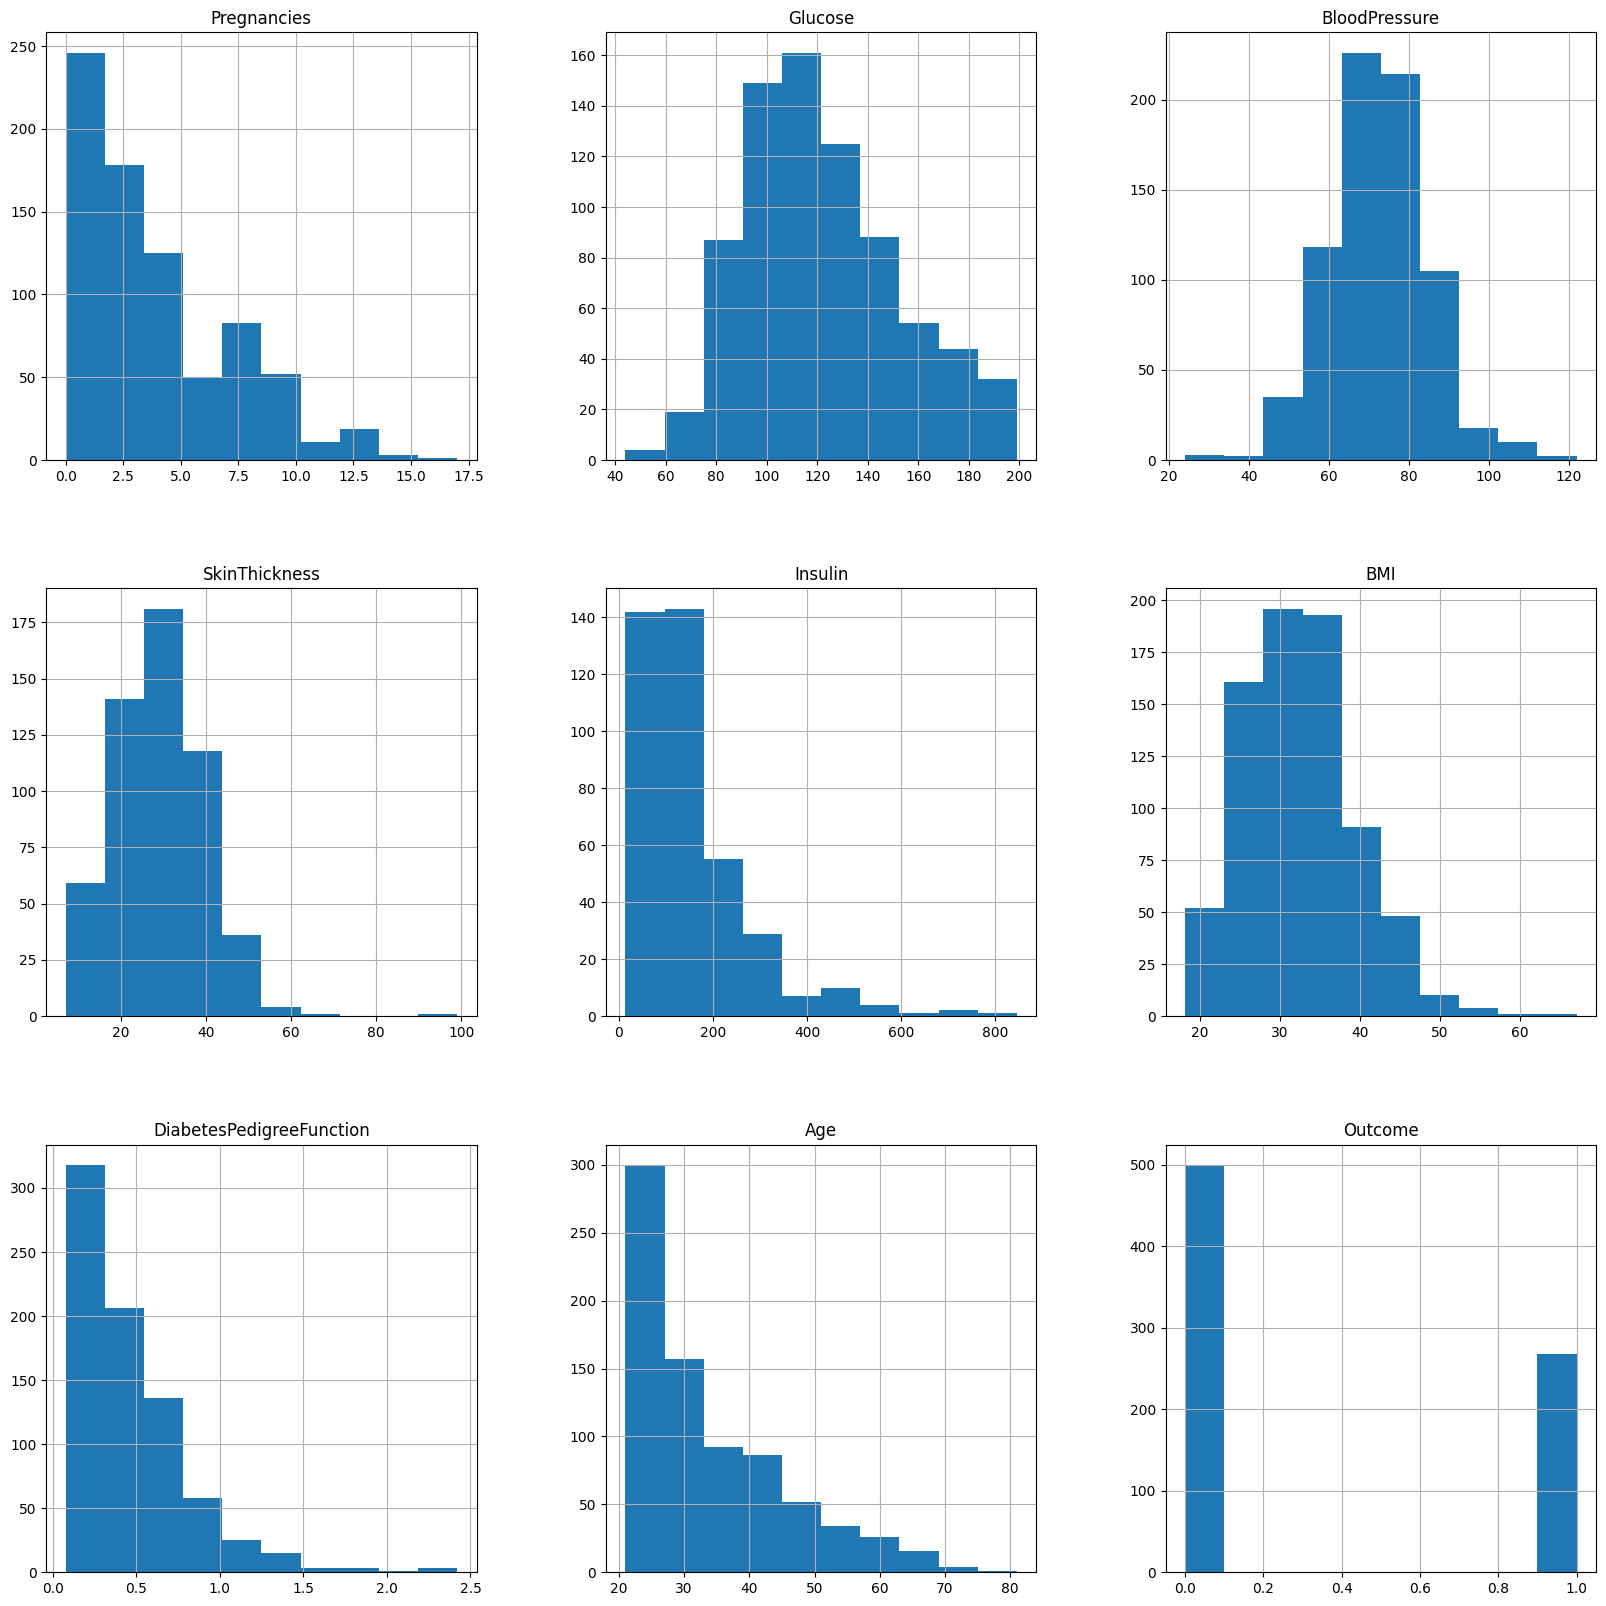

In [14]:
# visualize pandas histogram
dataset_clean.hist(figsize = (20, 20))
plt.show()

From the histogram, we can observe:
- 'Glucose', 'BloodPressure', 'SkinThickness', and 'BMI' are approximately normal -> replace NaN values with mean
- 'Insulin' is skewed -> replace NaN values with median

In [15]:
# replace NaN values with mean
dataset_clean['Glucose'].fillna(dataset_clean['Glucose'].mean(), inplace = True)
dataset_clean['BloodPressure'].fillna(dataset_clean['BloodPressure'].mean(), inplace = True)
dataset_clean['SkinThickness'].fillna(dataset_clean['SkinThickness'].mean(), inplace = True)
dataset_clean['BMI'].fillna(dataset_clean['BMI'].mean(), inplace = True)

# replace NaN values with median
dataset_clean['Insulin'].fillna(dataset_clean['Insulin'].median(), inplace = True)

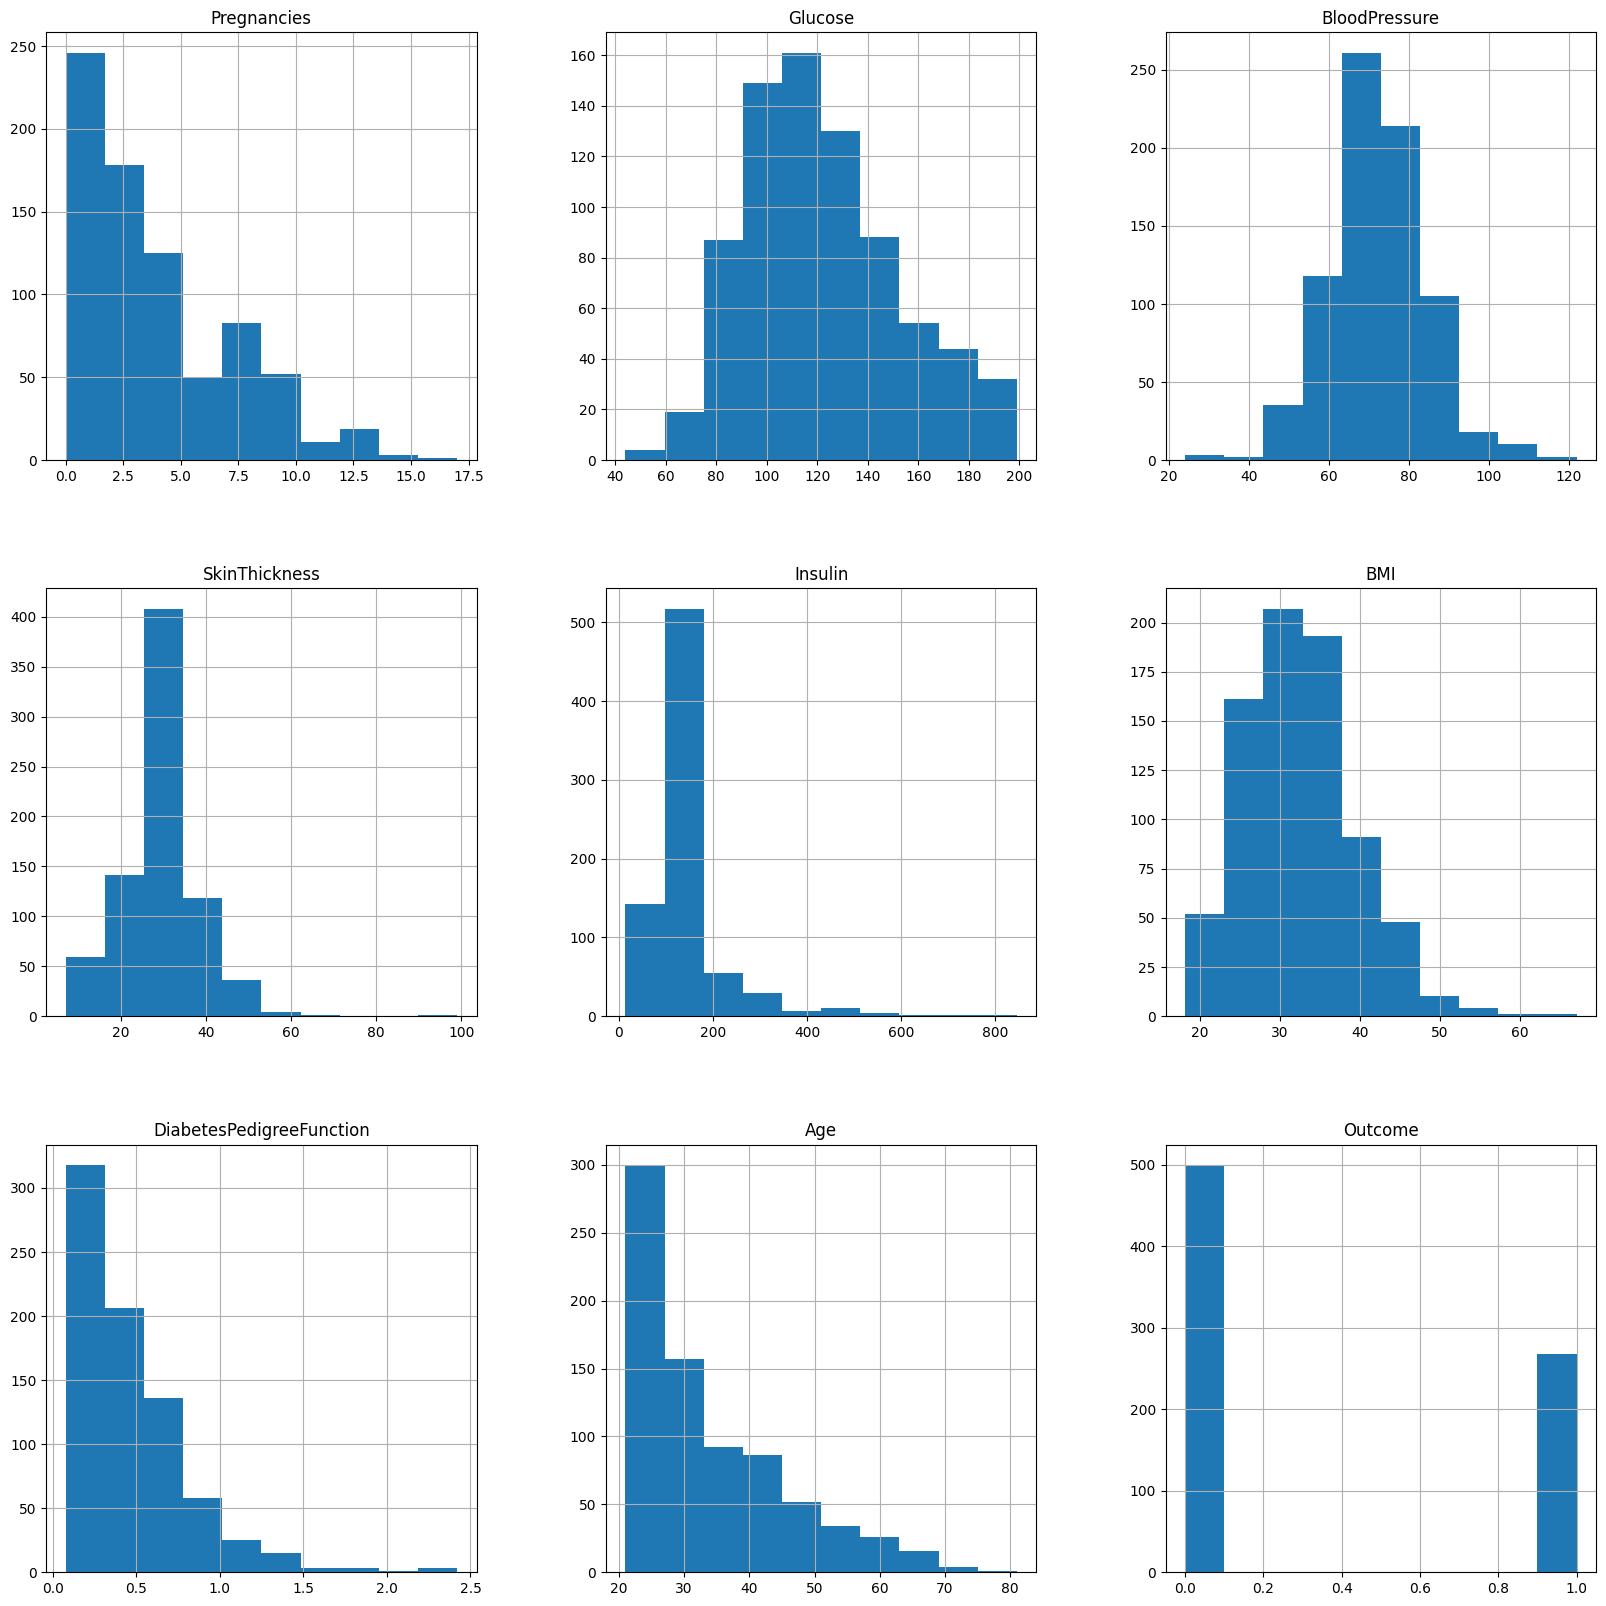

In [16]:
# visualize pandas histogram after cleaning
dataset_clean.hist(figsize = (20, 20))
plt.show()

In [17]:
# separate between feature and target in dataframes
X = dataset_clean.iloc[:, 0:8]
y = dataset_clean.iloc[:, 8]

# preview X
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.00000,125.0,33.6,0.627,50
1,1,85.0,66.0,29.00000,125.0,26.6,0.351,31
2,8,183.0,64.0,29.15342,125.0,23.3,0.672,32
3,1,89.0,66.0,23.00000,94.0,28.1,0.167,21
4,0,137.0,40.0,35.00000,168.0,43.1,2.288,33


In [18]:
# preview y
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

Number of negative cases:  500
Number of positive cases:  268


c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


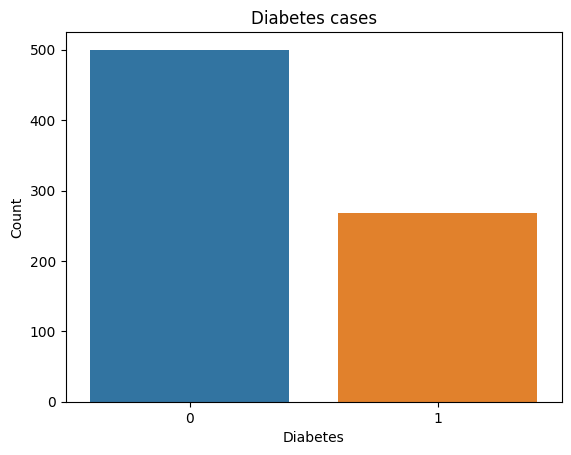

In [24]:
# visualize y values
N, P = y.value_counts()
print('Number of negative cases: ', N)
print('Number of positive cases: ', P)

# plot y values
sns.countplot(y, label = 'Count')
plt.title('Diabetes cases')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()


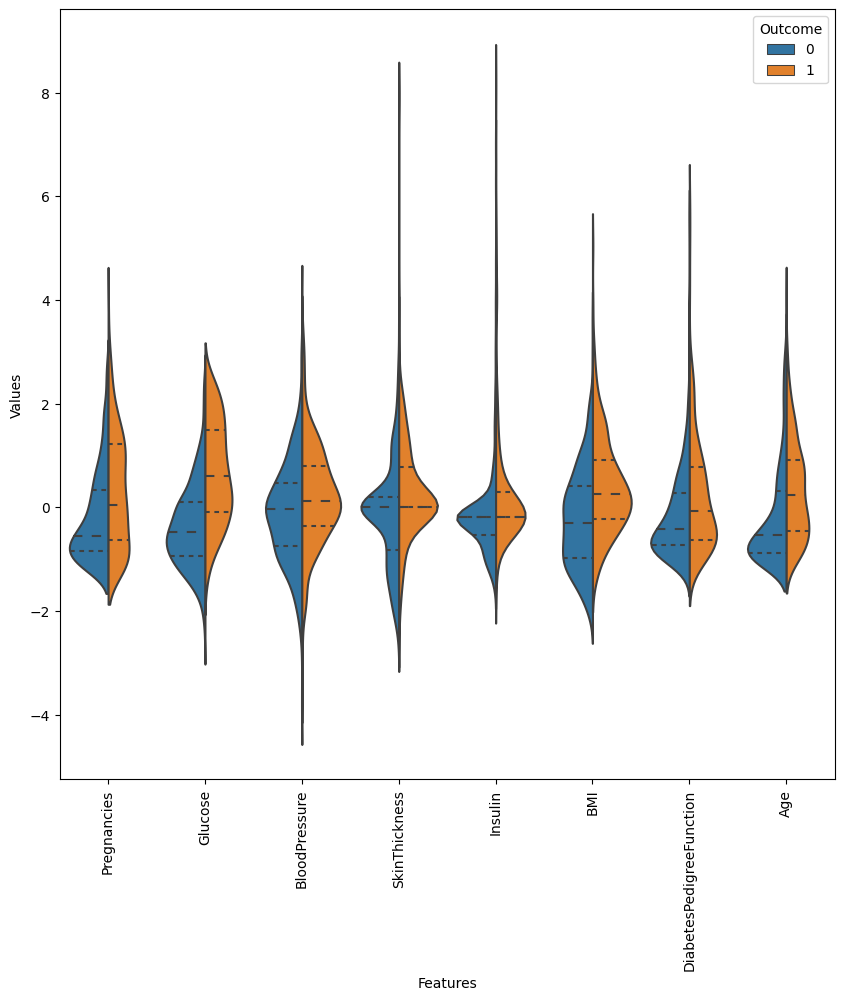

In [26]:
# standardize data clean dataset
y_vis = y
X_vis = X

X_std = (X_vis - X_vis.mean()) / X_vis.std()

# visualize features in a violin plot
data_vis = pd.concat([y_vis, X_std], axis=1)
data_vis = pd.melt(data_vis, id_vars="Outcome", var_name="Features", value_name='Values')

plt.figure(figsize=(10,10))
ax = sns.violinplot(x="Features", y="Values", hue="Outcome", data=data_vis, split=True, inner="quart")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

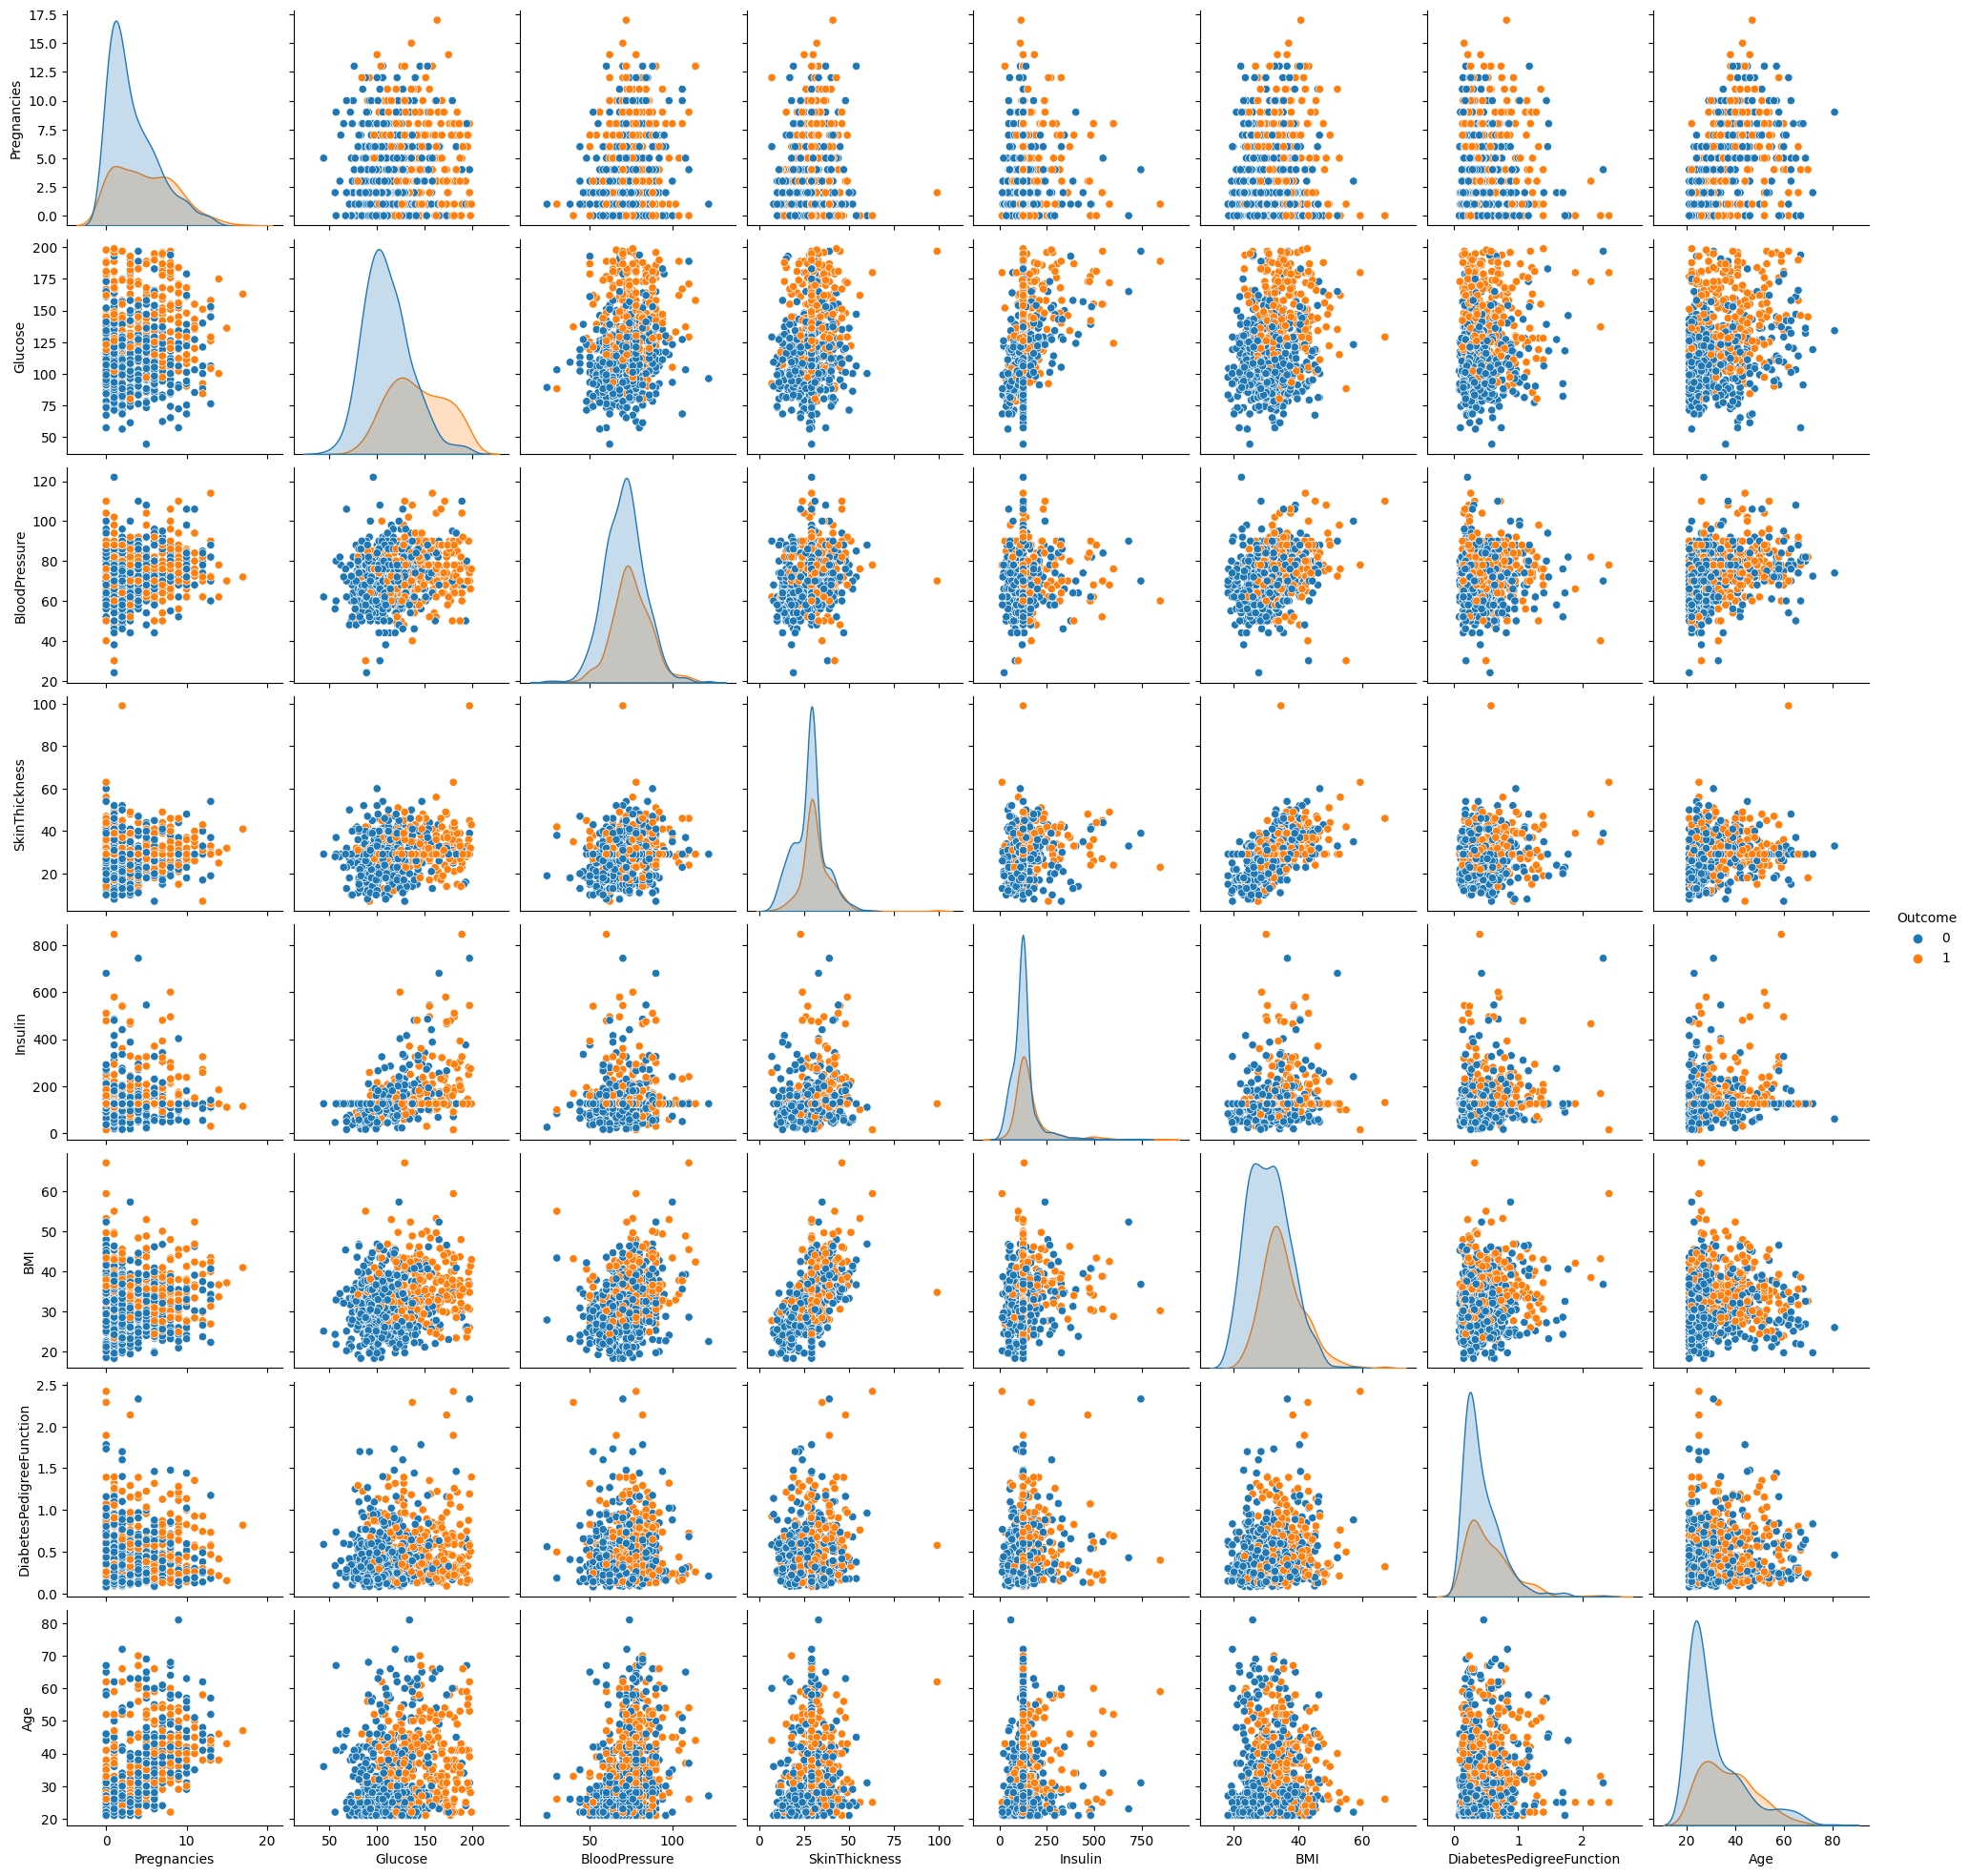

In [29]:
# visualize features in a pair plot
sns.pairplot(dataset_clean, hue='Outcome')
plt.show()

From the above visualizations, there doesn't seem to be much correlation between two variables. We can get a more precise measurement through the heatmap which shows Pearson's Correlation Coefficient.

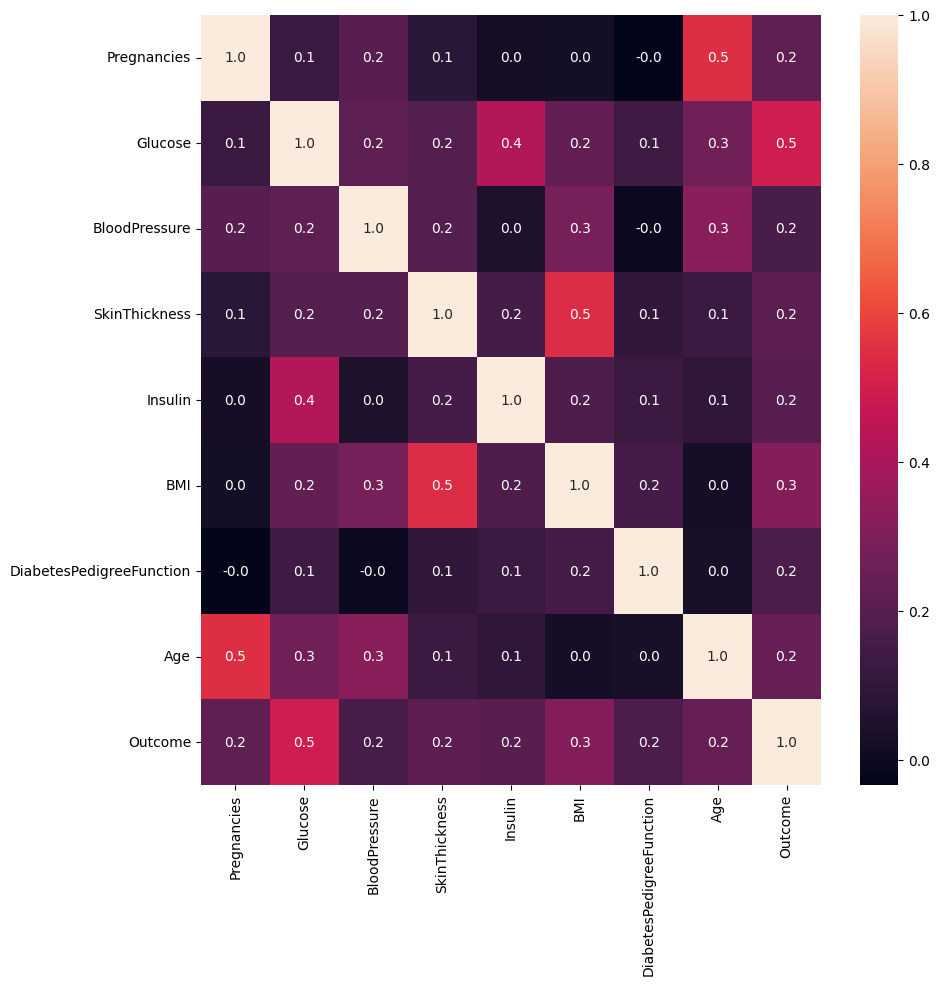

In [30]:
# create heatmap
corr = dataset_clean.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.1f')
plt.show()

As seen in the heatmap, none of the feature pairs are strongly correlated with each other, hence we may need to use all of them in the final feature set for training.

### Training the model

To train the model, we use the standardized features in X_std and the output label in y.

In [31]:
# print X_std preview
X_std.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639530,0.864545,-0.033496,6.650687e-01,-0.181423,0.166183,0.468187,1.425067
1,-0.844335,-1.205376,-0.529514,-1.745201e-02,-0.181423,-0.851976,-0.364823,-0.190548
2,1.233077,2.014501,-0.694853,8.082669e-16,-0.181423,-1.331965,0.604004,-0.105515
3,-0.844335,-1.073952,-0.529514,-6.999727e-01,-0.540290,-0.633799,-0.920163,-1.040871
4,-1.141108,0.503130,-2.678923,6.650687e-01,0.316360,1.547971,5.481337,-0.020483


In [32]:
# print y preview
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

#### Creating training and test sets

In [33]:
# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.2, random_state = 0, stratify=y)

# print X_train preview
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
22,0.936304,2.441627,1.454556,8.082669e-16,-0.181423,1.067982,-0.063008,0.659776
497,-0.547562,-1.336800,-0.033496,-1.610000e+00,-0.748664,-0.342896,0.226735,-0.700742
395,-0.547562,0.174571,-1.190871,-5.862193e-01,1.555029,-0.691979,3.404849,-0.700742
381,-1.141108,-0.548258,-0.364175,-8.137262e-01,-0.181423,-1.811955,-0.711910,-0.955839
258,-0.844335,2.343059,-1.852227,-1.496247e+00,2.712663,-0.953792,0.552695,-0.785774


In [49]:
# create machine learning model
#rfc = LogisticRegression()
rfc = RandomForestClassifier(n_estimators=100, random_state=0)

# fit model
rfc.fit(X_train, y_train)

# predict train set results
y_pred_train = rfc.predict(X_train)

# print classification report training set
print('Training Set')
print(classification_report(y_train, y_pred_train))

# predict test set results
y_pred = rfc.predict(X_test)

# print classification report
print('Test Set')
print(classification_report(y_test, y_pred))

# print confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))


Training Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       214

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614

Test Set
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       100
           1       0.72      0.57      0.64        54

    accuracy                           0.77       154
   macro avg       0.76      0.73      0.74       154
weighted avg       0.77      0.77      0.77       154

Confusion matrix:  [[88 12]
 [23 31]]


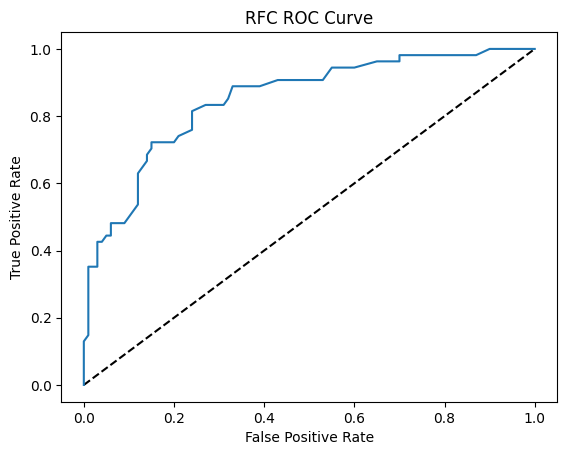

In [50]:
# create roc curve
y_pred_prob = rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# plot roc curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RFC ROC Curve')
plt.show()

In [51]:
# print roc auc score
print('ROC AUC score: ', roc_auc_score(y_test, y_pred_prob))

ROC AUC score:  0.8503703703703704
